# Optimizing the Continuum Normalization Function

Below is an improved implementation of the polynomial continuum normalization.

In [1]:
import numpy as np
from astropy.io import fits
import glob
import lmfit
import matplotlib.pyplot as plt

In [2]:
files = glob.glob('../data/*.fits')
fname = files[0]
with fits.open(fname) as f:
    flux = f[1].data['flux']
    lmbd = 10**f[1].data['loglam']
    ivar = f[1].data['ivar']

In [3]:
def plot(x, y, init, best, cont, norm, figsize=(20,7), save_loc=None, save_fmt='png'):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].plot(x, y, 'b', label='data')
    axes[0].plot(x, init, 'k--', label='initial fit')
    axes[0].plot(x, best, 'r-', label='best fit')
    axes[0].legend(loc='best')
    
    axes[1].plot(x, y)
    axes[1].plot(x, cont)
    
    if save_loc is None:
        plt.show()
    else:
        plt.savefig(save_loc, format=save_fmt)
    
    plt.figure(figsize=figsize)
    plt.plot(x, norm)
    plt.ylim(0,2)

In [4]:
def normalize(x, y, cont_fn, absr_fn, make_plot=False, debug=False):
    if debug:
        print('Entering normalize()')
    
    cont_model, cont_params = cont_fn(x, y)
    absr_model, absr_params = absr_fn(x, y)
    tmodel = cont_model - absr_model
    params = cont_params + absr_params

    if debug:
        print('\nModel constructed with initial params:\n')
        params.pretty_print()

    mfit = tmodel.fit(y, params, x=x)

    if debug:
        print('\nModel fitted with final params:\n')
        mfit.params.pretty_print()

    y_cont = cont_model.eval(mfit.params, x=x)
    y_norm = y/y_cont

    if make_plot:
        plot(x, y, mfit.init_fit, mfit.best_fit, y_cont, y_norm)

    return y_norm, mfit.params

In [5]:
def one_absr_model(center, id, depth, sigma):
    model = lmfit.models.PseudoVoigtModel(prefix='v'+str(id)+'_')
    model.set_param_hint('center', value=center, vary=False)
    model.set_param_hint('amplitude', value=depth, min=0, vary=True)
    model.set_param_hint('sigma', value=sigma, vary=True)
    model.set_param_hint('fraction', value=0.5, vary=True)
    return model

def get_absr_model(x, y=flux):
    max_line = 9
    balmer = (np.arange(3, max_line+1))**2
    balmer = 3645.07 * (balmer/(balmer-4))

    depth = 5*np.median(y)
    sigma = 5

    absorb_model = one_absr_model(balmer[0], 0, depth, sigma)
    for i in range(1, len(balmer)):
        absorb_model += one_absr_model(balmer[i], i, depth, sigma)

    return absorb_model, absorb_model.make_params()

In [11]:
def get_poly_model(x, y):
    poly_model = lmfit.models.PolynomialModel(4, prefix='poly_')
    return poly_model, poly_model.guess(y, x=x)


<ipython-input-7-642f2bc926c8>:3: RankWarning: Polyfit may be poorly conditioned
  return poly_model, poly_model.guess(y, x=x)


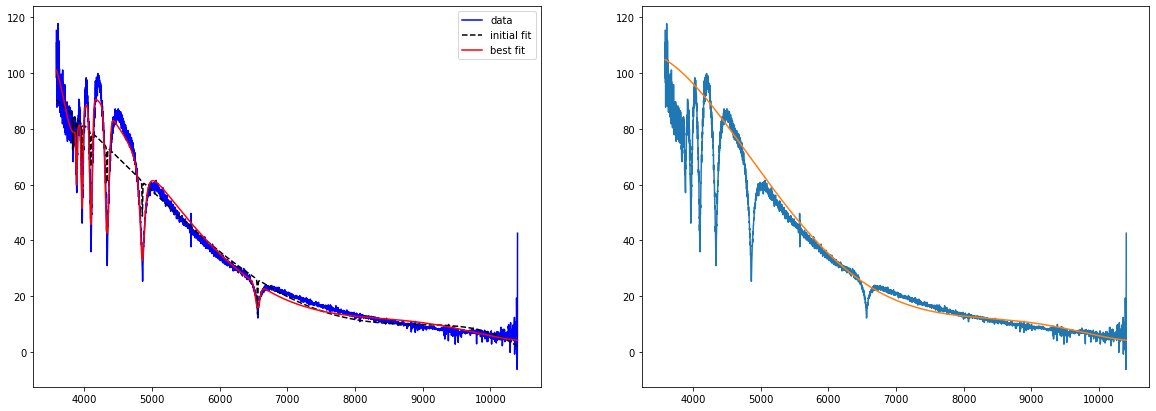

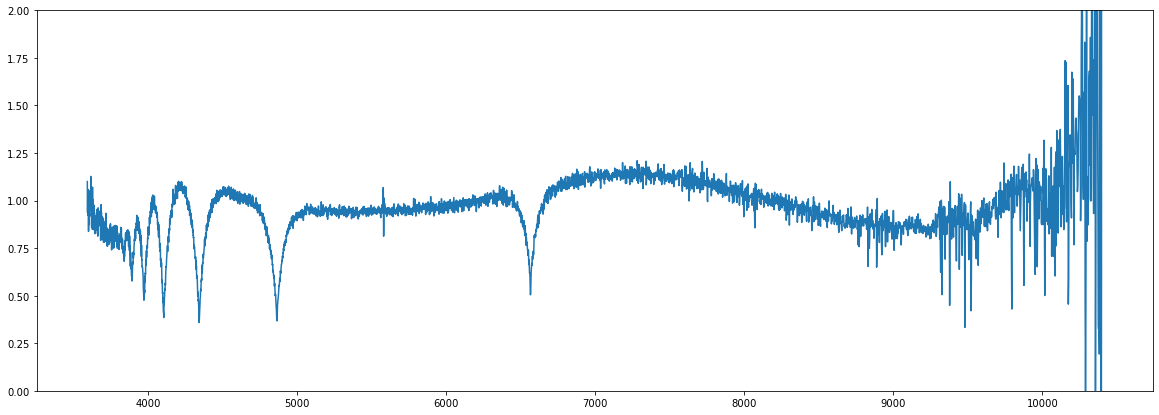

In [8]:
poly_norm, poly_pars = normalize(lmbd, flux, get_poly_model, get_absr_model,
                                 make_plot=True,
                                 debug=False)

In [9]:
poly_pars.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
poly_c0         -417.3     -inf      inf     None     True     None     None
poly_c1         0.4117     -inf      inf     None     True     None     None
poly_c2       -0.0001029     -inf      inf     None     True     None     None
poly_c3       6.635e-09     -inf      inf     None     True     None     None
poly_c4       7.395e-13     -inf      inf     None     True     None     None
poly_c5       -1.155e-16     -inf      inf     None     True     None     None
poly_c6       4.109e-21     -inf      inf     None     True     None     None
v0_amplitude     685.1        0      inf     None     True     None     None
v0_center         6561     -inf      inf     None    False     None     None
v0_fraction   1.936e-06        0        1     None     True     None     None
v0_fwhm          77.63     -inf      inf     None    False 2.0000000*v0_sigma     None
v0_height        8.291     -inf      inf     None    Fal